In [1]:
import math
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split

# Readin data

## X Data

In [2]:
data = pd.read_parquet("data/raw/france.parquet")
data.dropna(axis=0, how='any', inplace=True)

In [3]:
data

meteo_variable_id,rr24,t,t_max,t_min,t_avg,DJ_0,cumul_DJ_0,DJ_6,cumul_DJ_6,cumul_rr24,id_sta
date,,,,,,,,,,,
2017-09-01,2.857143,285.55,16.55,12.55,14.578571,14.55,14.55,8.55,8.55,2.857143,7005
2017-09-02,4.925000,284.85,19.05,11.15,14.637500,15.10,29.65,9.10,17.65,7.782143,7005
2017-09-03,2.175000,283.75,19.85,9.55,14.600000,14.70,44.35,8.70,26.35,9.957143,7005
2017-09-04,0.775000,287.75,20.45,14.75,17.200000,17.60,61.95,11.60,37.95,10.732143,7005
2017-09-05,0.087500,290.85,20.15,17.35,18.700000,18.75,80.70,12.75,50.70,10.819643,7005
...,...,...,...,...,...,...,...,...,...,...,...
2022-05-30,-0.037500,290.75,25.65,17.05,21.325000,21.35,28323.75,15.35,17960.55,2892.122381,7790
2022-05-31,0.125000,290.45,27.35,17.35,22.625000,22.35,28346.10,16.35,17976.90,2892.247381,7790
2022-06-01,0.050000,291.75,26.75,18.25,22.600000,22.50,28368.60,16.50,17993.40,2892.297381,7790


## Position info

In [4]:
position = pd.read_csv("data/raw/postesSynop.csv", sep=";")

In [5]:
position

,ID,Nom,Latitude,Longitude,Altitude
0,7005,ABBEVILLE,50.136000,1.834000,69
1,7015,LILLE-LESQUIN,50.570000,3.097500,47
2,7020,PTE DE LA HAGUE,49.725167,-1.939833,6
3,7027,CAEN-CARPIQUET,49.180000,-0.456167,67
4,7037,ROUEN-BOOS,49.383000,1.181667,151
...,...,...,...,...,...
57,81401,SAINT LAURENT,5.485500,-54.031667,5
58,81405,CAYENNE-MATOURY,4.822333,-52.365333,4
59,81408,SAINT GEORGES,3.890667,-51.804667,6
60,81415,MARIPASOULA,3.640167,-54.028333,106


In [6]:
Id = position["ID"].astype(str)
for i in range(len(Id)):
    if len(Id[i]) < 5:
        Id[i] = '0' + Id[i]

In [7]:
Id

0     07005
1     07015
2     07020
3     07027
4     07037
      ...  
57    81401
58    81405
59    81408
60    81415
61    89642
Name: ID, Length: 62, dtype: object

## Y Data (production)

In [8]:
production = pd.read_parquet("data/raw/franceagrimer-rdts-surfs-multicrops.parquet")
production = production.drop(production[production["n_dep"] == "2A"].index)
production = production.drop(production[production["n_dep"] == "2B"].index)
production = production.drop(production[production["n_dep"].astype(int) > 95].index)

In [9]:
provinces = {7005: 80, 7015: 59, 7020: 50, 7027: 14, 7037: 76, 7072: 51, 7110: 29, 7117: 22, 7130: 35, 7139: 61, 7149: 91, 7168: 10, 7181: 54, 7190: 67, 7207: 56, 7222: 44, 7240: 37, 7255: 18, 7280: 21, 7299: 68, 7314: 17, 7335: 86, 7434: 87, 7460: 63, 7471: 43, 7481: 69, 7510: 33, 7535: 46, 7558: 12, 7577: 26, 7591: 5, 7607: 40, 7621: 65, 7627: 9, 7630: 31, 7643: 34, 7650: 13, 7661: 83, 7690: 6, 7747: 66, 67005: 10}

In [10]:
production

,n_dep,dep,surf_2017,surf_2018,surf_2019,surf_2020,surf_2021,surf_2022,rdt_2017,rdt_2018,rdt_2019,rdt_2020,rdt_2021,rdt_2022,prod_2017,prod_2018,prod_2019,prod_2020,prod_2021,crop
0,75,PARIS,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,OP
1,77,SEINE-ET-MARNE,24855.0,26685.0,37970.0,34730.0,24805.0,28775.0,72.0,68.0,79.0,53.0,70.0,0.0,178956.0,181458.0,299963.0,184069.0,173635.0,OP
2,78,YVELINES,4480.0,3890.0,6015.0,6770.0,4110.0,4275.0,65.0,62.0,78.0,51.0,67.0,0.0,29120.0,24118.0,46917.0,34527.0,27537.0,OP
3,91,ESSONNE,10600.0,11485.0,15950.0,13635.0,9440.0,10950.0,68.0,69.0,78.0,54.0,73.0,0.0,72080.0,79247.0,124410.0,73629.0,68912.0,OP
4,92,HAUTS DE SEINE,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,OP
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
100,05,HAUTES ALPES,141.0,150.0,176.0,210.0,235.0,235.0,112.0,105.0,84.2,79.6,70.5,0.0,1579.0,1575.0,1482.0,1672.0,1657.0,MA
101,06,ALPES MARITIMES,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,MA
102,13,BOUCHES-DU-RHONE,879.0,834.0,895.0,850.0,899.0,899.0,81.7,86.1,75.5,68.4,81.5,0.0,7178.0,7181.0,6760.0,5814.0,7323.0,MA
103,83,VAR,232.0,308.0,304.0,390.0,359.0,359.0,81.3,70.4,66.9,60.1,83.5,0.0,1886.0,2167.0,2035.0,2345.0,2997.0,MA


# Linear Regression

In [11]:
crop = "OP"

In [12]:
crops = production["crop"].unique()
stations = data["id_sta"].unique()

In [13]:
lr = LinearRegression()

## Learn - Year - Region/Country - rr24, DJ_0 - rdt - OP

### Each province, Per year, is treated separately. The whole country learns together. 

In [14]:
def init_x():
    for i in stations:
        if i in provinces:
            data_station = data[data["id_sta"] == i]
            year_position = 0

            for j in range(2017, 2023):
                rain = 0
                rad = 0
                for k in range(year_position, len(data_station)):
                    if data_station.index[k].year == j:
                        rain += data_station["rr24"][k]
                        rad += data_station["DJ_0"][k]
                    else:
                        year_position = k
                        break
                total_rain[str(provinces[i]) + "_" + str(j)] = rain
                total_useful_rad[str(provinces[i]) + "_" + str(j)] = rad

In [15]:
def init_y():
    for i in total_rain:
        n_dep0, year = i.split('_')
        r_year = production['n_dep'].map(lambda x : x == n_dep0)
        r_crop = production['crop'].map(lambda x : x == crop)
        rdt = production[r_year & r_crop]["rdt_" + year].values
        if rdt.size > 0:
            if rdt[0]:
                total_OP_rdt[i] = rdt[0]

In [16]:
def init_list():
    data_list = []
    OP_rdt_list = []

    for i in total_OP_rdt:
        if i in total_rain:
            data_list.append(np.array([total_rain[i], total_useful_rad[i]]))
            OP_rdt_list.append(total_OP_rdt[i])

    data_list = np.array(data_list)
    OP_rdt_list = np.array(OP_rdt_list)
    
    return data_list, OP_rdt_list

In [17]:
total_rain = {}
total_useful_rad = {}
total_OP_rdt = {}
init_x()

def init():
    init_y()
    return init_list()

data_array, OP_rdt_array = init()

### Degre 0

In [18]:
def predict_zero():
    predict_zero = OP_rdt_array.mean()
    
    RMSE = math.sqrt(((predict_zero - OP_rdt_array) ** 2).sum() / len(OP_rdt_array))
    rRMSE = RMSE / OP_rdt_array.mean()
    
    return rRMSE

In [19]:
predict_zero()

0.25293414870821573

### Degre 1

In [20]:
def predict_one(times):
    sum_RMSE = 0
    
    for i in range(times):
        X_train, X_test, y_train, y_test = train_test_split(data_array, OP_rdt_array, test_size=0.2)
        lr.fit(X_train, y_train)
        y_predict = lr.predict(X_test)
        
        RMSE = math.sqrt(((y_predict - y_test) ** 2).sum() / len(y_test))
        rRMSE = RMSE / y_test.mean()
        sum_RMSE += rRMSE

    return sum_RMSE / times

In [21]:
predict_one(1000)

0.25227374603708425

### Degre 2

In [22]:
def predict_two(times):
    sum_RMSE = 0
    
    for i in range(times):
        X_train, X_test, y_train, y_test = train_test_split(data_array, OP_rdt_array, test_size=0.2)
        X_train_2 = np.concatenate([X_train ** 2, X_train], axis=1)
        lr.fit(X_train_2, y_train)
        X_test_2 = np.concatenate([X_test ** 2, X_test], axis=1)
        y_predict_2 = lr.predict(X_test_2)
        
        RMSE = math.sqrt(((y_predict_2 - y_test) ** 2).sum() / len(y_test))
        rRMSE = RMSE / y_test.mean()
        
        sum_RMSE += rRMSE

    return sum_RMSE / times

In [23]:
predict_two(1000)

0.23287113488017827

### Degre 3

In [24]:
def predict_three(times):
    sum_RMSE = 0
    
    for i in range(times):
        X_train, X_test, y_train, y_test = train_test_split(data_array, OP_rdt_array, test_size=0.2)
        X_train_3 = np.concatenate([X_train ** 3, X_train ** 2, X_train], axis=1)
        lr.fit(X_train_3, y_train)
        X_test_3 = np.concatenate([X_test ** 3, X_test ** 2, X_test], axis=1)
        y_predict_3 = lr.predict(X_test_3)
        
        RMSE = math.sqrt(((y_predict_3 - y_test) ** 2).sum() / len(y_test))
        rRMSE = RMSE / y_test.mean()
        
        sum_RMSE += rRMSE

    return sum_RMSE / times

In [25]:
predict_three(1000)

0.2250264705316141

### Degre n

In [26]:
def predict_n(n, times):
    if n == 0:
        return predict_zero()

    sum_RMSE = 0
    
    for i in range(times):
        X_train, X_test, y_train, y_test = train_test_split(data_array, OP_rdt_array, test_size=0.2)
        X_train_n = X_train
        X_test_n = X_test
        for i in range(2, n + 1):
            X_train_n = np.concatenate([X_train ** i, X_train_n], axis=1)
            X_test_n = np.concatenate([X_test ** i, X_test_n], axis=1)
        
        lr.fit(X_train_n, y_train)
        y_predict_n = lr.predict(X_test_n)
        
        RMSE = math.sqrt(((y_predict_n - y_test) ** 2).sum() / len(y_test))
        rRMSE = RMSE / y_test.mean()
        
        sum_RMSE += rRMSE

    return sum_RMSE / times

In [27]:
def test_degree_n(times):
    degree = np.linspace(0, 10, 11)
    for i in degree:
        rRMSE_degree[crop + i.astype(int).astype(str)] = predict_n(i.astype(int), times)

In [28]:
times = 1000
rRMSE_degree = {}
test_degree_n(times)

### Other grains

In [29]:
times = 1000

In [30]:
def draw():
    fig, ax = plt.subplots(1, 1, figsize=(15, 5))
    for crop in crops:
        rRMSE_plot = []
        x_plot = np.linspace(0, 10, 11)
        for i in range(11):
            rRMSE_plot.append(rRMSE_degree[crop + str(i)])
        plt.plot(x_plot, rRMSE_plot)
    plt.legend(crops)

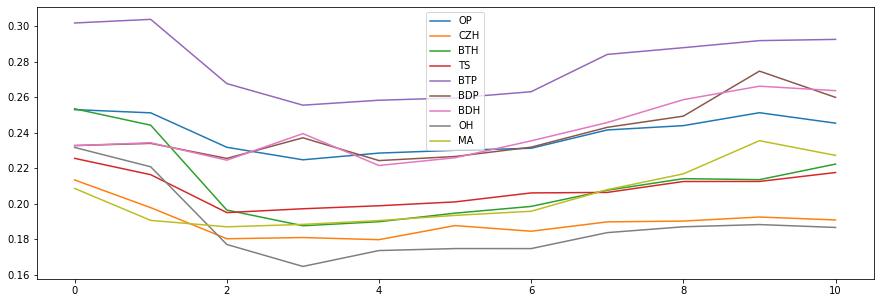

In [31]:
rRMSE_degree = {}
total_rain = {}
total_useful_rad = {}
init_x()

for crop in crops:
    total_OP_rdt = {}

    data_array, OP_rdt_array = init()
    
    test_degree_n(times)

draw()

In [32]:
best_predict = {}

for crop in crops:
    temp_list = []
    for i in range(11):
        temp_list.append(rRMSE_degree[crop + str(i)])
    best_predict[crop + "_" + str(temp_list.index(min(temp_list)))] = min(temp_list)

In [33]:
best_predict

{'OP_3': 0.2246569039284271,
 'CZH_4': 0.1796609663838037,
 'BTH_3': 0.18750149936814978,
 'TS_2': 0.19492623315501806,
 'BTP_3': 0.2554383236268331,
 'BDP_4': 0.22422659210875043,
 'BDH_4': 0.22144783157372638,
 'OH_3': 0.16457177088287916,
 'MA_2': 0.18690687065699277}